# Structured Perceptron: Rain Grid Cost Modeling

This notebook loads the `rain_grid_dataset.csv` dataset and trains a structured perceptron to approximate the grid's cost function (higher cost in lower rows).


## Setup
We treat cost as a structured label. For each state `(row, col)`, we predict a cost label using a score function `w · phi(x, y)` and update the weights with a perceptron rule when the prediction is wrong.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except Exception:
    plt.rcParams.update({"figure.dpi": 120})


In [2]:
DATA_PATH = "rain_grid_dataset.csv"
df = pd.read_csv(DATA_PATH)
df.head()


,episode,step,state_row,state_col,action,next_row,next_col,reward,cell_cost,terminated,truncated
0,0,0,0,0,1,0,1,-1.0,1.0,False,False
1,0,1,0,1,1,0,2,-1.0,1.0,False,False
2,0,2,0,2,1,0,3,-1.0,1.0,False,False
3,0,3,0,3,1,0,4,-1.0,1.0,False,False
4,0,4,0,4,2,1,4,-2.0,2.0,False,False


In [3]:
df.shape


(1600, 11)

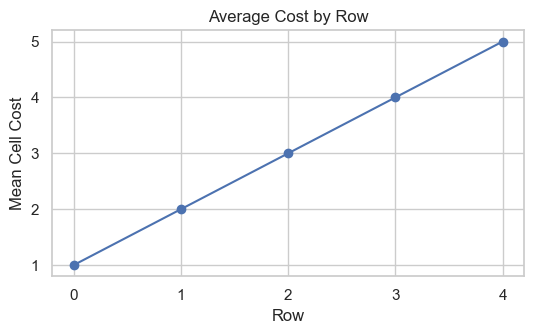

In [4]:
row_stats = df.groupby("next_row")["cell_cost"].mean().reset_index()
plt.figure(figsize=(5.5, 3.5))
plt.plot(row_stats["next_row"], row_stats["cell_cost"], marker="o")
plt.title("Average Cost by Row")
plt.xlabel("Row")
plt.ylabel("Mean Cell Cost")
plt.xticks(row_stats["next_row"])
plt.tight_layout()
plt.show()


## Structured Perceptron
We model a score `w · phi(x, y)` where `x = (row, col)` and `y` is a cost label. The feature map places the base features into the slice for the chosen label.


In [5]:
label_values = np.sort(df["cell_cost"].unique()).astype(int)
label_to_index = {label: i for i, label in enumerate(label_values)}

X = df[["next_row", "next_col"]].to_numpy(dtype=np.int64)
y = df["cell_cost"].astype(int).to_numpy()
y_idx = np.array([label_to_index[val] for val in y], dtype=np.int64)

def base_features(row, col):
    return np.array([1.0, row, col, row * col], dtype=np.float32)

num_labels = len(label_values)
base_dim = base_features(0, 0).shape[0]
W = np.zeros((num_labels, base_dim), dtype=np.float32)

def predict_label_index(row, col):
    feats = base_features(row, col)
    scores = W @ feats
    return int(np.argmax(scores))

epochs = 20
rng = np.random.default_rng(0)
history = []

for epoch in range(epochs):
    indices = rng.permutation(len(X))
    errors = 0
    for i in indices:
        row, col = X[i]
        feats = base_features(row, col)
        pred_idx = predict_label_index(row, col)
        true_idx = y_idx[i]
        if pred_idx != true_idx:
            W[true_idx] += feats
            W[pred_idx] -= feats
            errors += 1
    acc = 1 - errors / len(X)
    history.append(acc)

history


[0.87875,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

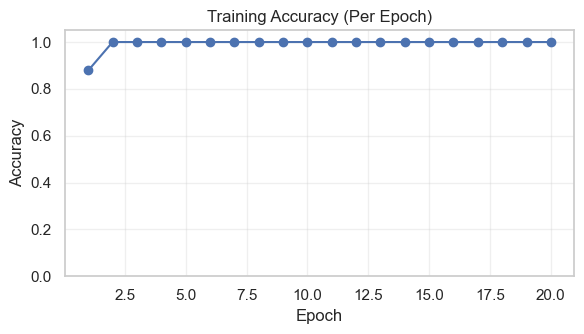

In [6]:
plt.figure(figsize=(6, 3.5))
plt.plot(np.arange(1, len(history) + 1), history, marker="o")
plt.ylim(0.0, 1.05)
plt.title("Training Accuracy (Per Epoch)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


## Visual Comparison: True vs Predicted Cost Grid
We aggregate the true costs from the dataset and compare against the learned perceptron predictions for each grid cell.


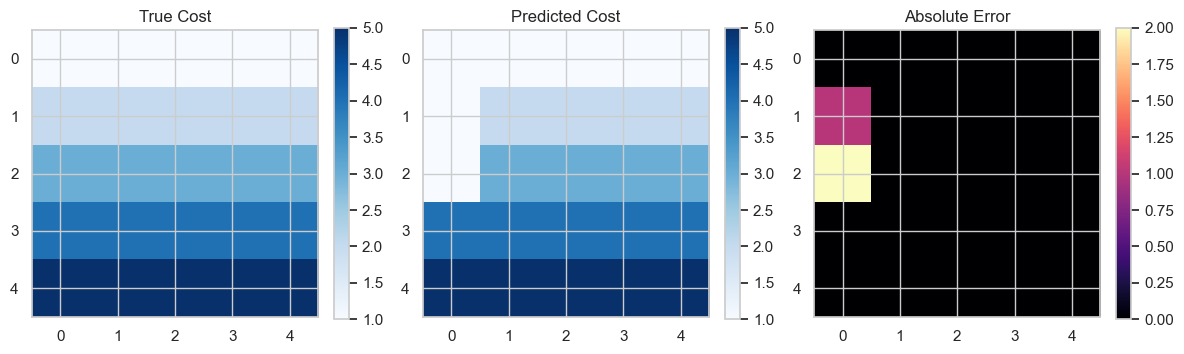

In [7]:
grid_size = int(max(df["next_row"].max(), df["next_col"].max()) + 1)
true_grid = np.full((grid_size, grid_size), np.nan, dtype=np.float32)
grouped = df.groupby(["next_row", "next_col"])["cell_cost"].mean()
for (r, c), cost in grouped.items():
    true_grid[int(r), int(c)] = cost

for r in range(grid_size):
    for c in range(grid_size):
        if np.isnan(true_grid[r, c]):
            true_grid[r, c] = 1 + r

pred_grid = np.zeros_like(true_grid)
for r in range(grid_size):
    for c in range(grid_size):
        pred_idx = predict_label_index(r, c)
        pred_grid[r, c] = label_values[pred_idx]

error_grid = np.abs(true_grid - pred_grid)

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
vmin = label_values.min()
vmax = label_values.max()

im0 = axes[0].imshow(true_grid, cmap="Blues", vmin=vmin, vmax=vmax)
axes[0].set_title("True Cost")
axes[0].set_xticks(range(grid_size))
axes[0].set_yticks(range(grid_size))
plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(pred_grid, cmap="Blues", vmin=vmin, vmax=vmax)
axes[1].set_title("Predicted Cost")
axes[1].set_xticks(range(grid_size))
axes[1].set_yticks(range(grid_size))
plt.colorbar(im1, ax=axes[1], fraction=0.046)

im2 = axes[2].imshow(error_grid, cmap="magma", vmin=0)
axes[2].set_title("Absolute Error")
axes[2].set_xticks(range(grid_size))
axes[2].set_yticks(range(grid_size))
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.tight_layout()
plt.show()


## Notes
- The model is intentionally simple and uses only a few base features.
- You can add richer features (e.g., one-hot rows/cols) to make the learned cost map even sharper.
